# 설치

In [ ]:
!pip install konlpy
!pip install wordcloud

! apt-get install fonts-nanum

##################################################

!sudo apt -y update
!sudo apt install -y wget curl unzip
!wget http://archive.ubuntu.com/ubuntu/pool/main/libu/libu2f-host/libu2f-udev_1.1.4-1_all.deb
!dpkg -i libu2f-udev_1.1.4-1_all.deb
!wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
!dpkg -i google-chrome-stable_current_amd64.deb
!CHROME_DRIVER_VERSION=`curl -sS chromedriver.storage.googleapis.com/LATEST_RELEASE`
#!wget -N https://chromedriver.storage.googleapis.com/$CHROME_DRIVER_VERSION/chromedriver_linux64.zip -P /tmp/
#!wget -N https://edgedl.me.gvt1.com/edgedl/chrome/chrome-for-testing/116.0.5845.96/linux64/chromedriver-linux64.zip
!wget -N https://storage.googleapis.com/chrome-for-testing-public/122.0.6261.57/linux64/chromedriver-linux64.zip
!unzip -o /tmp/chromedriver-linux64.zip -d /tmp/

!chmod +x /tmp/chromedriver-linux64/chromedriver

!mv /tmp/chromedriver-linux64/chromedriver /usr/local/bin/chromedriver
!pip install selenium



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 39.0 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (6,989 kB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 121749 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-c

# 라이브러리

In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import csv
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from konlpy.tag import Kkma

###################################
from bs4 import BeautifulSoup
from selenium import webdriver
import time
from selenium.webdriver.common.keys import Keys # 엔
import datetime
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException

from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
import re

ModuleNotFoundError: No module named 'konlpy'

# 네이버 뉴스에서 해당 기간 동안의 뉴스 제목을 수집해 워드 클라우드를 생성

In [ ]:

def create_wordcloud(start_date, end_date, search_keyword, font_path):
    # Naver news search URL
    url = f"https://search.naver.com/search.naver?where=news&sm=tab_jum&query={search_keyword}"

    # Create a list to store all the titles
    titles_list = []
    num_pages = 3

    # Loop through each page
    for page in range(1, num_pages + 1):
        # Construct the URL for each page with date parameters
        url_with_date = f"{url}&pd=3&ds={start_date}&de={end_date}&start={(page - 1) * 10 + 1}"

        # Send a GET request to the URL and get the response
        response = requests.get(url_with_date)

        # Check if the request was successful
        if response.status_code == 200:
            # Get the HTML content of the page
            html_content = response.text

            # Parse the HTML content using BeautifulSoup
            soup = BeautifulSoup(html_content, 'html.parser')

            # Find all the news title elements on the page
            news_titles = soup.find_all('a', {'class': 'news_tit'})

            # Append each title to the list
            for title in news_titles:
                titles_list.append(title.text.strip())

        else:
            print(f"Failed to retrieve the page content for page {page}")

    # Create a DataFrame from the titles list
    df = pd.DataFrame({'title': titles_list})

    # 형태소 분석을 위한 Kkma 객체 생성
    kkma = Kkma()

    # 명사 추출
    nouns = df['title'].apply(lambda x: kkma.nouns(x))
    nouns = nouns.explode()

    # 단어의 길이가 2 이상인 단어들로 구성된 DataFrame 생성
    df_word = pd.DataFrame({'word': nouns})
    df_word['count'] = df_word['word'].str.len()
    df_word = df_word.query('count >= 2')

    # 단어 빈도수 계산
    df_word = df_word.groupby('word', as_index=False).count().sort_values('count', ascending=False)

    # 워드 클라우드 생성
    wordcloud = WordCloud(background_color='white', width=800, height=400, font_path=font_path)
    wordcloud.generate_from_frequencies(dict(zip(df_word['word'], df_word['count'])))

    # 워드 클라우드 시각화
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'


# 품목 코드 반환

In [ ]:
def return_commodity_code(year, month, item):
      """
      이 사용자 함수는 품목명에 대한 품목 코드 return 함.
      품목 코드가 많아 HS10단위 고정 및 상단 품목코드 선택.
      """
      # ChromeDriver를 위한 옵션 설정
      options = Options()

      # 브라우저를 실제로 열지 않고 백그라운드에서 실행하기 위해 headless 모드 활성화
      options.add_argument("--headless")

      # 브라우저 창의 크기를 1920x1080으로 설정
      options.add_argument('window-size=1920x1080')

      # /dev/shm 파티션 사용을 비활성화하여 Docker 같은 샌드박스 환경에서 발생할 수 있는 문제 방지
      options.add_argument("--disable-dev-shm-usage")

      # Chrome을 안전하지 않은 방식으로 실행하여 샌드박스 모드 비활성화
      # 샌드박스 없이 Chrome을 실행하는 것은 보안상 권장되지 않지만, 일부 환경에서 필요할 수 있음
      options.add_argument("--no-sandbox")

      driver = webdriver.Chrome(
          options=options
      )
      driver.get(f"https://www.kotra.or.kr/bigdata/visualization/korea#search/ALL/ALL/{year}/{month}/exp") # 해당 년도, 월 사이트 이동
      time.sleep(1)

      # 품목 HS CODE 클릭
      time.sleep(1)
      driver.find_element(by=By.XPATH, value="/html/body/div[1]/div[3]/div[3]/div/ul/li[4]/a").click()

      # input 입력 및 클릭
      time.sleep(1)
      search_input = driver.find_element(By.ID, "search-word") # 품목명 입력
      search_input.send_keys(item + Keys.ENTER)

      driver.find_element(by=By.XPATH, value='/html/body/div[1]/div[3]/div[3]/div/ul/li[4]/div/div[3]/div[2]/button').click() # 검색창 클릭

      original_window = driver.current_window_handle # 위 클릭 시 새로운 창 뜨기에 원래 화면 저장하기 위함

      # HS6 선택X, HS10단위로 통일
      time.sleep(1)
      all_windows = driver.window_handles  # 모든 창 핸들 가져오기
      new_window = [window for window in all_windows if window != original_window][0]
      driver.switch_to.window(new_window)  # 새 창으로 전환

      # 새 창에서 요소 찾기
      WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, '/html/body/div[2]/div[4]/div[1]/div[5]/div[3]/div[2]/ul/li[2]/button')))

      # 새 창에서  바로 품목 코드 저장
      original_string = driver.find_element(By.XPATH, '/html/body/div[2]/div[4]/div[1]/div[5]/div[3]/div[2]/ul/li[1]/div/div[1]/span[1]/span').text


      # re를 사용하여 숫자를 제외한 모든 문자 제거
      cleaned_string = re.sub(r'[^0-9]', '', original_string)

      # 드라이버 종료
      driver.quit()
      print(cleaned_string)
      return cleaned_string





# 수출입 데이터 크롤링

In [ ]:
def return_month_export_inport_crawler(year, month, cleaned_string):
    # ChromeDriver를 위한 옵션 설정
    options = Options()

    # 브라우저를 실제로 열지 않고 백그라운드에서 실행하기 위해 headless 모드 활성화
    options.add_argument("--headless")

    # 브라우저 창의 크기를 1920x1080으로 설정
    options.add_argument('window-size=1920x1080')

    # /dev/shm 파티션 사용을 비활성화하여 Docker 같은 샌드박스 환경에서 발생할 수 있는 문제 방지
    options.add_argument("--disable-dev-shm-usage")

    # Chrome을 안전하지 않은 방식으로 실행하여 샌드박스 모드 비활성화
    # 샌드박스 없이 Chrome을 실행하는 것은 보안상 권장되지 않지만, 일부 환경에서 필요할 수 있음
    options.add_argument("--no-sandbox")

    input_value = cleaned_string
    driver = webdriver.Chrome(options=options)
    driver.get(f"https://www.kotra.or.kr/bigdata/visualization/korea#search/ALL/ALL/{year}/{month}/exp")  # 해당 년도, 월 사이트 이동
    time.sleep(1)
    driver.find_element(by=By.XPATH, value="/html/body/div[1]/div[3]/div[3]/div/ul/li[4]/a").click() # 품목 HS CODE 클릭
    time.sleep(1)
    driver.find_element(by=By.XPATH, value="/html/body/div[1]/div[3]/div[3]/div/ul/li[4]/div/div[2]/div/label[2]").click() # HS CODE 10자리 radius 클릭
    time.sleep(1)
    search_input = driver.find_element(By.ID, "search-code") # 검색창 찾기
    time.sleep(1)
    search_input.send_keys(input_value + Keys.ENTER) # 검색창에 입력
    time.sleep(1)
    driver.find_element(by=By.XPATH, value='/html/body/div[1]/div[3]/div[3]/div/ul/li[4]/div/div[5]/div[2]/div/div/div[2]/div[1]/div[3]/div[2]/div/div/div').click() # 검색창 클릭
    time.sleep(5)

    # 품목코드마다 수출지역 개수가 다름.
    # 행의 수를 알 수 없으므로, 존재하는 동안 계속 데이터를 가져옴

    # 수출 금액 크롤링 및 평균
    index = 1
    export = []
    inport = []
    while True:
        try:
            # XPath에서 변화하는 부분을 index 변수로 대체
            xpath = f"/html/body/div[1]/div[3]/div[4]/div/ul/li[3]/div/div/div/div/div/div[2]/div[1]/div[3]/div[2]/div/div/div[{index}]/div[4]"


            # 해당 XPath를 가진 요소 찾기
            element = driver.find_element(By.XPATH, xpath)

            # 요소의 텍스트(데이터)를 data 리스트에 추가
            export.append(element.text)

            # 인덱스 증가
            index += 1
        except NoSuchElementException:
            # 더 이상 요소를 찾을 수 없으면 while 루프를 종료
            break

    # 수입 금액 크롤링 및 평균
    index=1
    while True:
        try:
          # XPath에서 변화하는 부분을 index 변수로 대체
          xpath = f"/html/body/div[1]/div[3]/div[4]/div/ul/li[3]/div/div/div/div/div/div[2]/div[1]/div[3]/div[2]/div/div/div[{index}]/div[5]"

          # 해당 XPath를 가진 요소 찾기
          element = driver.find_element(By.XPATH, xpath)

            # 요소의 텍스트(데이터)를 data 리스트에 추가
          inport.append(element.text)

          index +=1
        except NoSuchElementException:
          break

    number_list = [int(s.replace(',', '')) for s in export]

    # 평균 계산
    if len(number_list) > 0:
      average = sum(number_list) / len(number_list)
    else:
      average = 0

    number_list = [int(s.replace(',', '')) for s in inport]

    if len(number_list) > 0:
      average2 = sum(number_list) / len(number_list)
    else:
      average2 = 0

    print(export)
    print(inport)
    print(str(year)+'년 ' + str(month)+'월 ' + '수출입 데이터 수집 완료!')
    print()
    return average, average2

# 실행

In [ ]:
from datetime import datetime

# 현재 날짜와 시간 가져오기
now = datetime.now()

# 현재 연도와 월 추출
current_year = now.year
current_month = now.month

current_year, current_month


(2024, 2)

시작 날짜 ex) 2024-02-01: 2024-02-01
끝 날짜 ex) 2024-02-20: 2024-02-20
검색할 상품 ex) 한국 폴란드 수출: 한국 폴란드 수출


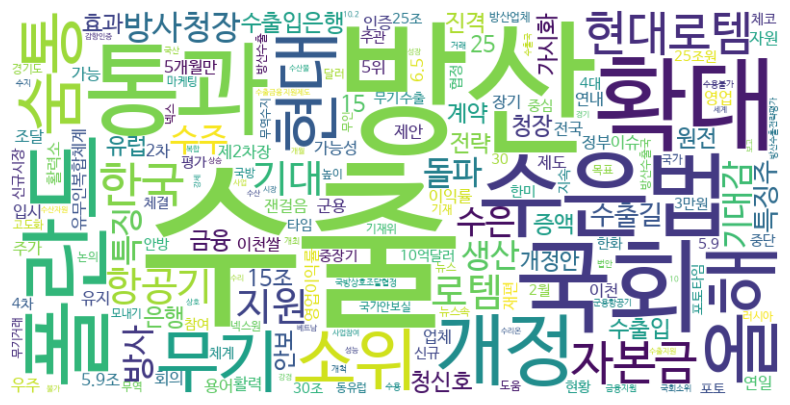

In [ ]:
start_date = input("시작 날짜 ex) 2024-02-01: ")
end_date = input("끝 날짜 ex) 2024-02-20: ")
search = input("검색할 상품 ex) 한국 폴란드 수출: ")

create_wordcloud(start_date, end_date, search, font_path)


In [ ]:
start_year = int(input("년도 입력 ex) 2023: "))
start_month = int(input("월 입력 ex) 09: "))
item = input("검색할 상품 입력 ex) 소주: ")

년도 입력 ex) 2023: 2023
월 입력 ex) 09: 01
검색할 상품 입력 ex) 소주: 소주


In [ ]:
#월 별 평균 수출입 금액 담기 위한 리스트

exports = []
inports = []
for y in range(start_year, current_year + 1):
    # 시작 연도인 경우
    if y == start_year:
        start_m = start_month
        end_m = 12
    # 현재 연도인 경우
    elif y == current_year:
        start_m = 1
        end_m = current_month-1
    # 중간에 있는 연도들
    else:
        start_m = 1
        end_m = 12
    for m in range(start_m, end_m+1):
        cleaned_string = return_commodity_code(y, m, item)
        export, inport = return_month_export_inport_crawler(y, m, cleaned_string)
        exports.append(export)
        inports.append(inport)

2208904000
['2,879,527', '2,209,482', '1,559,732', '473,622', '282,334', '254,000', '249,598', '241,158', '167,650', '156,880', '104,471', '95,400', '66,077', '58,922', '56,600', '55,907', '35,270', '34,028', '33,487', '21,720', '18,000', '16,380']
['110,828', '69', '69', '0', '24', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
2023년 1월 수출입 데이터 수집 완료!

2208904000
['2,212,270', '1,888,447', '695,543', '576,999', '259,272', '252,420', '244,887', '163,528', '163,510', '136,930', '99,145', '97,127', '82,323', '79,669', '77,302', '65,568', '60,439', '43,190', '41,225', '29,835', '29,790', '26,400']
['118,854', '97', '16', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
2023년 2월 수출입 데이터 수집 완료!

2208904000
['10,466,744,358', '9,758,384,501', '4,628,939,993', '2,411,551,782', '2,204,137,384', '1,662,711,698', '1,656,726,997', '1,572,935,051', '1,384,661,038', '1,085,615,212', '916,329,352', '894,765,503', '89

In [ ]:
print(exports)
print(inports)


[412283.86363636365, 332991.7727272727, 2085002544.0, 1860912093.0, 1986914316.5454545, 2061213704.7272727, 1944772689.3181818, 2019367428.8636363, 377787.2727272727, 417191.63636363635, 501968.36363636365, 403616.45454545453, 370384.7272727273]
[5045.0, 5407.590909090909, 1947585088.9545455, 1697240498.090909, 1796908410.090909, 1794254567.409091, 1713926058.6363637, 1687414347.8636363, 9939.227272727272, 7480.363636363636, 6789.909090909091, 7624.5, 4237.954545454545]


csv 파일 내보내기

In [ ]:
start = str(start_year) + '-' + str(start_month)
# 인덱스 생성
index = pd.date_range(start=start, periods=len(exports), freq='MS').strftime('%Y-%m')
# DataFrame 생성
df = pd.DataFrame({'export': exports, 'import': inports}, index=index)
print(df)

df.to_csv('export_import.csv', encoding='utf-8-sig')
df.to_excel(excel_writer='export_import.xlsx', encoding='utf-8-sig')

               export        import
2023-01  4.122839e+05  5.045000e+03
2023-02  3.329918e+05  5.407591e+03
2023-03  2.085003e+09  1.947585e+09
2023-04  1.860912e+09  1.697240e+09
2023-05  1.986914e+09  1.796908e+09
2023-06  2.061214e+09  1.794255e+09
2023-07  1.944773e+09  1.713926e+09
2023-08  2.019367e+09  1.687414e+09
2023-09  3.777873e+05  9.939227e+03
2023-10  4.171916e+05  7.480364e+03
2023-11  5.019684e+05  6.789909e+03
2023-12  4.036165e+05  7.624500e+03
2024-01  3.703847e+05  4.237955e+03


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

df = pd.read_csv("/content/export_import.csv",index_col=0)


In [16]:
df

,export,import
2023-01,4.122839e+05,5.045000e+03
2023-02,3.329918e+05,5.407591e+03
2023-03,2.085003e+09,1.947585e+09
2023-04,1.860912e+09,1.697240e+09
2023-05,1.986914e+09,1.796908e+09
2023-06,2.061214e+09,1.794255e+09
2023-07,1.944773e+09,1.713926e+09
2023-08,2.019367e+09,1.687414e+09
2023-09,3.777873e+05,9.939227e+03
2023-10,4.171916e+05,7.480364e+03


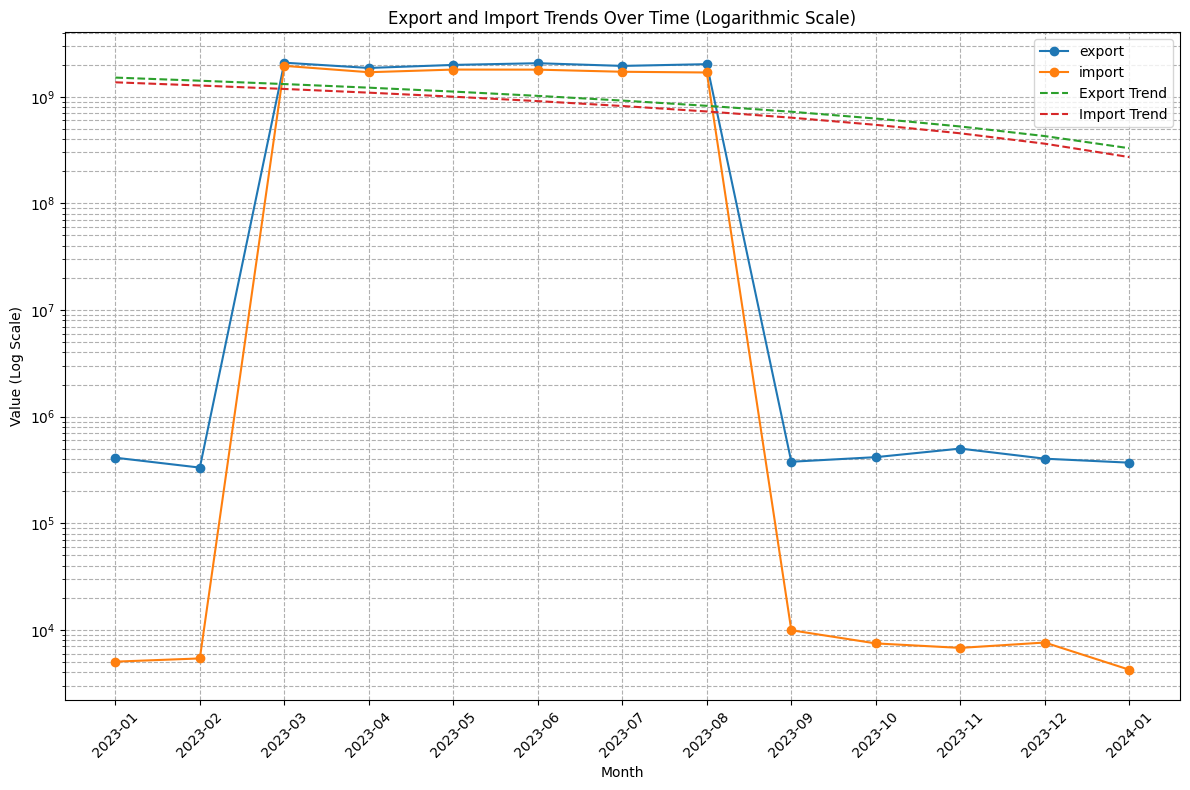

In [20]:
# Since there's a significant disparity in the scale of exports and imports, we'll use a logarithmic scale for the y-axis to improve the visualization.

x = np.arange(len(df.index))

export_slope, export_intercept, _, _, _ = linregress(x, df['export'])
import_slope, import_intercept, _, _, _ = linregress(x, df['import'])

df['ExportTrend'] = export_intercept + export_slope * x
df['ImportTrend'] = import_intercept + import_slope * x


plt.figure(figsize=(12, 8))

# Plotting with a logarithmic scale
plt.plot(df.index, df['export'], label='export', marker='o')
plt.plot(df.index, df['import'], label='import', marker='o')
plt.plot(df.index, df['ExportTrend'], label='Export Trend', linestyle='--')
plt.plot(df.index, df['ImportTrend'], label='Import Trend', linestyle='--')

plt.yscale('log')  # Set the y-axis to a logarithmic scale

plt.title('Export and Import Trends Over Time (Logarithmic Scale)')
plt.xlabel('Month')
plt.ylabel('Value (Log Scale)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, which="both", ls="--")  # Grid for both major and minor ticks
plt.tight_layout()

plt.show()
